*09/01/24*
Authors: Ismael Mendoza

Here I try to resolve the antithetical nature of the autocorrelation in nuts and come to a resolution about what I should clip to move on and have a conservative estimate on ESS.

In [1]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [2]:
import galsim 
import jax_galsim as xgalsim

2024-09-02 08:33:18.987058: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-02 08:33:41.764076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

In [5]:
from functools import partial

In [6]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [7]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [8]:
from bpd.chains import inference_loop

In [9]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [10]:
GPU = jax.devices('gpu')[0]

In [11]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [13]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [14]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

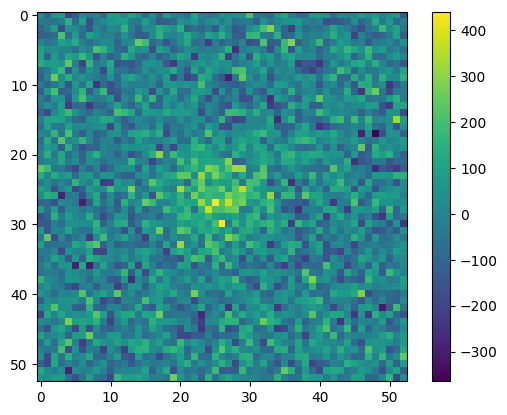

In [15]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [16]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [17]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

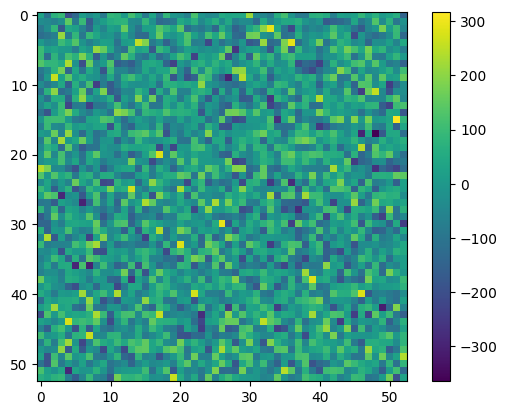

In [18]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

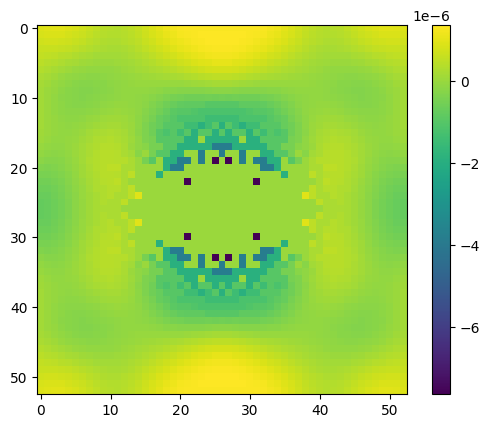

In [19]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [20]:
# gpu
# ERROR internal to jax_galsim! e.g. _hlr_factor inside Gaussian
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
# with jax.transfer_guard('disallow'):
#     draw_gal(**TRUE_PARAMS_GPU)

In [21]:
# timing makes sense
draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

98.3 μs ± 505 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
408 μs ± 2.74 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Multiple chain inference loop + warmup

In [24]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [25]:
TRUE_PARAMS

{'f': 4.5, 'hlr': 0.9, 'g1': 0.05, 'g2': 0.0, 'x': 0.0, 'y': 0.0}

In [54]:
random.ball(jax.random.key(45), 1, 2)

Array([0.2762116], dtype=float64)

In [86]:
# sample from ball around truth
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        

In [87]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal priors
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


In [88]:
N_CHAINS = 5

In [89]:
# get data
SEED = 42

data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [90]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [91]:
init_key, warmup_key, infer_key = jax.random.split(rng_key, 3)

In [92]:
init_keys = random.split(init_key, N_CHAINS)
init_positions = jax.vmap(sample_ball, in_axes=(0, None))(init_keys, TRUE_PARAMS_GPU)
init_positions['f'].shape, init_positions['f'].devices()

((5,), {CudaDevice(id=0)})

In [93]:
# warmup function to jit
def call_warmup(rng_key, init_positions, data, n_warmups, max_num_doublings):
    _logdensity = partial(_logprob_fn, data=data)
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=max_num_doublings, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # sometimes prevents divergences by decrasing final step size, although now priors should be wide enough..
    )
    return warmup.run(rng_key, init_positions, n_warmups) # (init_states, tuned_params), adapt_info

In [94]:
run_warmup = jax.vmap(jjit(partial(call_warmup, n_warmups=1000, max_num_doublings=5)), in_axes=(0, 0, None))
warmup_keys = jax.random.split(warmup_key, N_CHAINS)

In [96]:
(state, tuned_params), adapt_info = run_warmup(warmup_keys, init_positions, data_gpu) # compilation

In [103]:
init_positions['f']

Array([4.59032939, 4.46824819, 4.58641464, 4.40600449, 4.30153311],      dtype=float64)

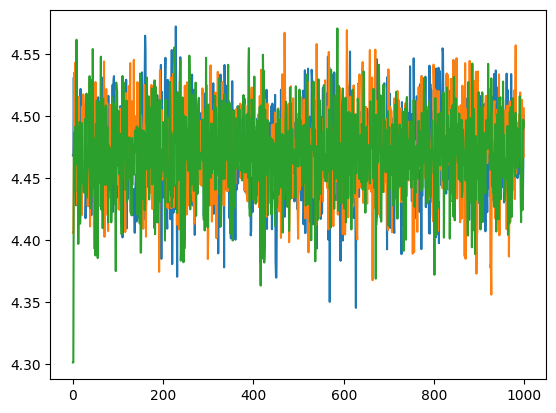

In [102]:
# see chain progression from different starting points
plt.plot(adapt_info.state.position['f'][1])
plt.plot(adapt_info.state.position['f'][3])
plt.plot(adapt_info.state.position['f'][4])

In [106]:
def do_inference(rng_key, init_state, step_size:float, inverse_mass_matrix, data, max_num_doublings:int, n_samples:int):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=max_num_doublings).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=n_samples) # state, info

In [107]:
inference_keys = jax.random.split(infer_key, N_CHAINS) 
run_inference = jax.vmap(
    jjit(partial(do_inference, max_num_doublings=5, n_samples=1000)), in_axes=(0, 0, 0, 0, None)
)
states, info = run_inference(inference_keys, state, tuned_params['step_size'], tuned_params['inverse_mass_matrix'], data_gpu)

In [108]:
samples = states.position
samples['f'].shape

(5, 1000)

## Investigate ESS

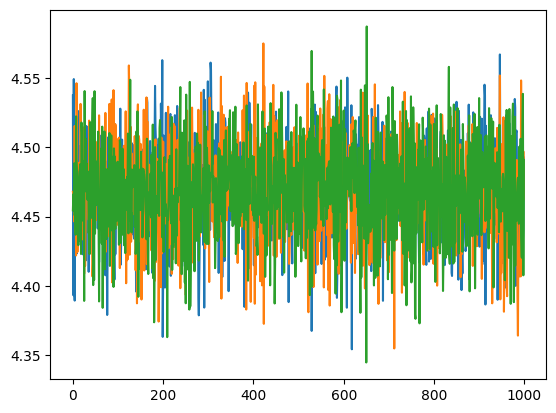

In [112]:
f = samples['f'] # chains look OK
plt.plot(f[0])
plt.plot(f[3])
plt.plot(f[4])

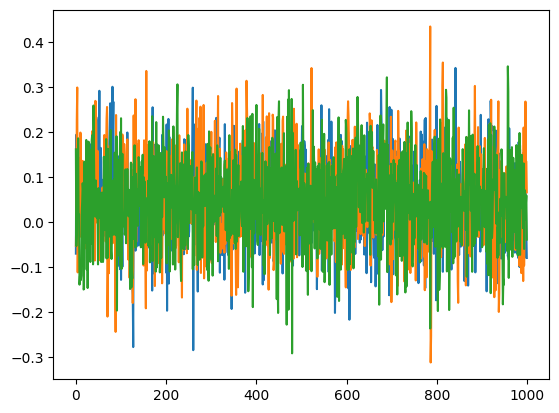

In [113]:
g1 = samples['g1'] # chains look OK
plt.plot(g1[0])
plt.plot(g1[3])
plt.plot(g1[4])

In [114]:
# initial look at ess and R-hat 
for p in samples:
    ess = effective_sample_size(samples[p], chain_axis=0, sample_axis=1)
    r_hat=potential_scale_reduction(samples[p], chain_axis=0, sample_axis=1) 

    print(p)
    print(ess)
    print(ess / samples[p].size)# all are larger than one! for all parameter 
    print(r_hat)
    print() 

f
6413.534362444618
1.2827068724889235
0.9995953852383997

g1
5876.3169647433715
1.1752633929486742
0.9998747145206013

g2
6381.730340184727
1.2763460680369454
1.0011635052242227

hlr
6296.262166505989
1.2592524333011978
0.9997540054535287

x
8060.599562749048
1.6121199125498096
1.0000009245951342

y
7790.672057059392
1.5581344114118783
0.9997580127404496



### autocorrelation

In [115]:
ac = az.autocorr(f, axis=-1)
ac.shape

(5, 1000)

(-0.2, 0.2)

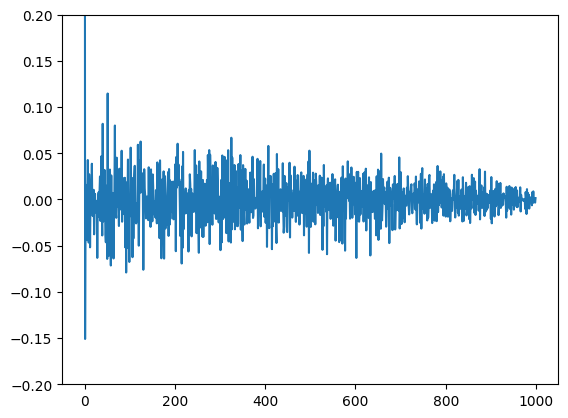

In [116]:
plt.plot(ac[0])
plt.ylim(-0.2, 0.2)

In [117]:
ac[0][15]

0.0047515528482870795

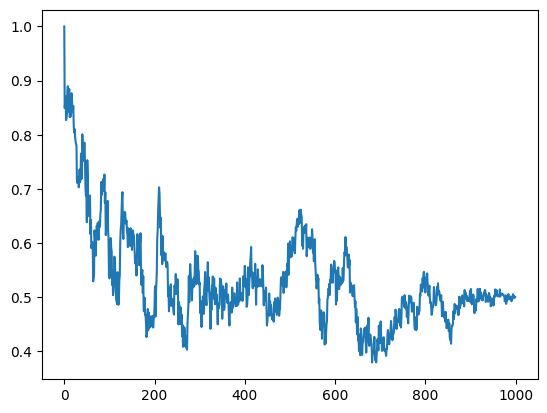

In [118]:
# cumsum
plt.plot(np.cumsum(ac[0]))

(-0.2, 0.2)

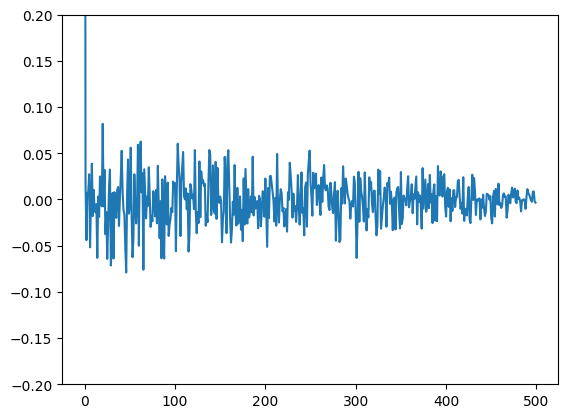

In [127]:
plt.plot(ac[0][::2])# even lags are not always positive
plt.ylim(-0.2, 0.2) 

In [125]:
ac[0][::2][2] == ac[0][4]

True

In [128]:
# sum of pairs of autocorr
Pm = []
for ii in range(499):
    Pm.append(ac[0][2*ii] + ac[0][2*ii+1])

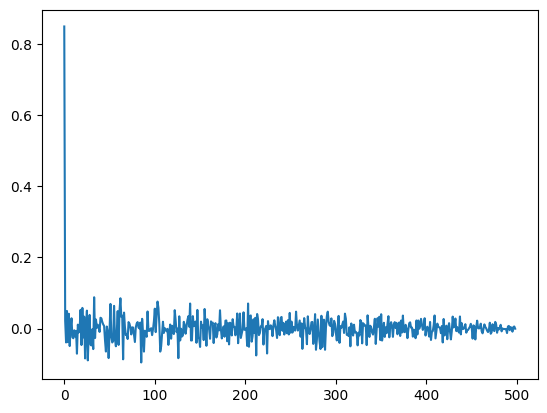

In [131]:
plt.plot(Pm) #negativ very quickly